In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [21]:
#Aquire the data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df = [df_train, df_test]

In [22]:
#Inspect the first 5 rows
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [23]:
#Determine the features in the dataset
#Categorical Data: Survived, Sex, Embarked, Pclass
#Continuous Data: Age, Fare, Sibsp, Parch
#Mixed Data: Ticket, Cabin
df_train.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

In [24]:
#Check for missing values and determine the data type of each feature
#Training dataset has missing values in Age, Cabin, and Embarked
#Test dataset has missing values in Age and Cabin
df_train.info()
print('--' * 40)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------     

In [25]:
df_train.drop(['Ticket', 'PassengerId', 'Cabin'], axis = 1, inplace = True)
df_test.drop(['Ticket', 'PassengerId', 'Cabin'], axis = 1, inplace = True)

In [26]:
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [27]:
####Analyzing correlation between non-null and catigorical and discrete features###

In [28]:
#We can see a large corrilcation (above 50%) amoung those in Pclass=1 and survival
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index = False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [29]:
#There is a correlation between survival and those that embarked from Cherbourg (Embark=C)
df_train[['Embarked', 'Survived']].groupby(['Embarked']).mean().reset_index()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


In [30]:
#Women had a higher survival rate than men
df_train[['Sex', 'Survived']].groupby(['Sex']).mean().reset_index()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [31]:
#There is zero correlation for certain values, may be better to create a new feature from these individual values
df_train[['SibSp', 'Survived']].groupby(['SibSp']).mean().sort_values(by = 'Survived', ascending = False).reset_index()

,SibSp,Survived
0,1,0.535885
1,2,0.464286
2,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [32]:
#There is zero correlation for certain values, may be better to create a new feature from these individual values
df_train[['Parch', 'Survived']].groupby(['Parch']).mean().sort_values(by = 'Survived', ascending = False).reset_index()

,Parch,Survived
0,3,0.600000
1,1,0.550847
2,2,0.500000
3,0,0.343658
4,5,0.200000
5,4,0.000000
6,6,0.000000


In [33]:
####Vizulizing Data####

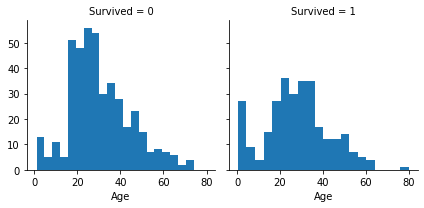

In [34]:
#Infants below the age of 4 had a high survival rate
#Many people between 15-30 did NOT survive
#Most passengers are betwwen 15-35
plot = sns.FacetGrid(df_train, col = 'Survived')
plot.map(plt.hist, 'Age', bins = 20)

C:\Users\17706\Documents\Coding\Conda\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


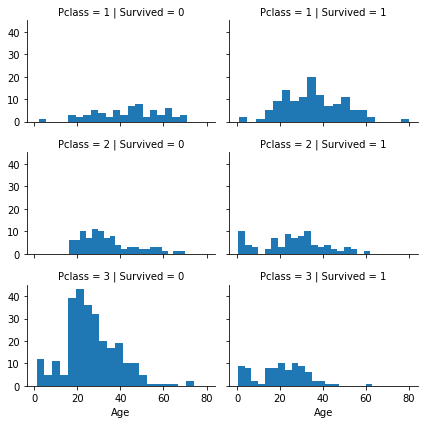

In [35]:
#Most people in Pclass=3 did not survive, while most in Pclass=1 did as stated before
#Manjority of infants survived, especially in Pclass=2
plot = sns.FacetGrid(df_train, col = 'Survived', row = 'Pclass', size = 2, aspect = 1.5)
plot.map(plt.hist, 'Age', bins = 20)

C:\Users\17706\Documents\Coding\Conda\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\17706\Documents\Coding\Conda\lib\site-packages\seaborn\axisgrid.py:648: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


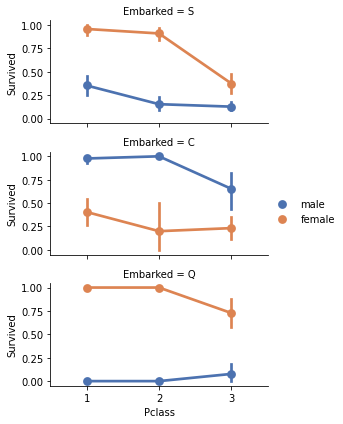

In [36]:
#Female passengers had a much better survival rate
#Exception being Embarked=C
#Survuval Rate for women in Pclass=3 drops signficantly for Embarked=S and Embarked=Q
plot = sns.FacetGrid(df_train, row='Embarked', height=2, aspect=2)
plot.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
plot.add_legend()

In [37]:
####Wrangle Data#####

In [38]:
#Extracting the title from passengers' names
for dataframe in df:
    dataframe['Title'] = dataframe.Name.str.extract('([A-Za-z]+)\.', expand = False)
pd.crosstab(df_train['Title'], df_train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [39]:
#Combining titles into more common ones to get a better sense of the data
#Both married and single women had high survival rates along with children
#Special members of the crew e.g. the Captain did not have a high survival rate
for dataframe in df:
    dataframe['Title'] = dataframe['Title'].replace(['Capt', 'Col', 'Countess', 'Don', 'Dr', 'Jonkheer', 'Lady', 'Major',
                                                    'Rev', 'Sir', 'Dona'], 'Rare')
    dataframe['Title'] = dataframe['Title'].replace('Mlle', 'Miss')
    dataframe['Title'] = dataframe['Title'].replace('Ms', 'Miss')
    dataframe['Title'] = dataframe['Title'].replace('Mme', 'Mrs')

df_train[['Title', 'Survived']].groupby(['Title']).mean().reset_index()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [40]:
#Convert the title and sex fetures into ordinal values
label = LabelEncoder()
for dataframe in df:
    dataframe['Title'] = label.fit_transform(dataframe['Title'])
    dataframe['Sex'] = label.fit_transform(dataframe['Sex'])
df_train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,7.2500,S,2
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,71.2833,C,3
2,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,7.9250,S,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,53.1000,S,3
4,0,3,"Allen, Mr. William Henry",1,35.0,0,0,8.0500,S,2
...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",1,27.0,0,0,13.0000,S,4
887,1,1,"Graham, Miss. Margaret Edith",0,19.0,0,0,30.0000,S,1
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,NaN,1,2,23.4500,S,1
889,1,1,"Behr, Mr. Karl Howell",1,26.0,0,0,30.0000,C,2


In [41]:
#Drop the 'Name' feature from the dataset
df_train = df_train.drop(['Name'], axis = 1)
df_test = df_test.drop(['Name'], axis = 1)
df_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,1,22.0,1,0,7.2500,S,2
1,1,1,0,38.0,1,0,71.2833,C,3
2,1,3,0,26.0,0,0,7.9250,S,1
3,1,1,0,35.0,1,0,53.1000,S,3
4,0,3,1,35.0,0,0,8.0500,S,2
...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,S,4
887,1,1,0,19.0,0,0,30.0000,S,1
888,0,3,0,NaN,1,2,23.4500,S,1
889,1,1,1,26.0,0,0,30.0000,C,2


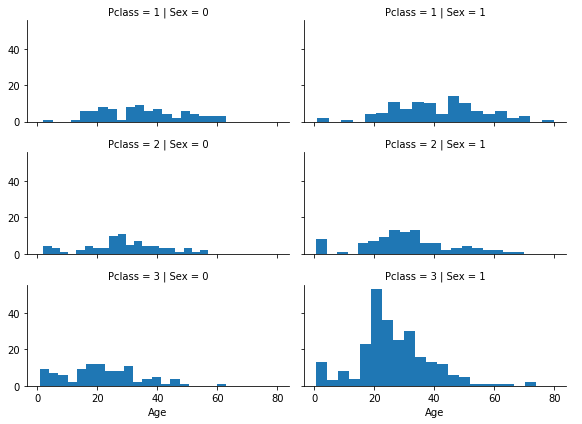

In [42]:
#Get a better idea of the age of men and women in all the Pclasses
plot = sns.FacetGrid(df_train, row = 'Pclass', col = 'Sex', height = 2, aspect = 2)
plot.map(plt.hist, 'Age', bins = 20)
plot.add_legend()

In [43]:
#Both men and women in Pclass=1 tend to be older and those in Pclass=3 are younger
df_train.groupby(['Sex', 'Pclass'])['Age'].agg('median')

Sex  Pclass
0    1         35.0
     2         28.0
     3         21.5
1    1         40.0
     2         30.0
     3         25.0
Name: Age, dtype: float64

In [44]:
#Replace the missing values in 'Age' with the mean value based on Sex and Pclass as observed above
df_train['Age'] = df_train['Age'].fillna(df_train.groupby(['Sex', 'Pclass'])['Age'].transform('mean'))
df_test['Age'] = df_test['Age'].fillna(df_test.groupby(['Sex', 'Pclass'])['Age'].transform('mean'))

df_train['Age'] = df_train['Age'].astype(int)
df_test['Age'] = df_test['Age'].astype(int)

df_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,1,22,1,0,7.2500,S,2
1,1,1,0,38,1,0,71.2833,C,3
2,1,3,0,26,0,0,7.9250,S,1
3,1,1,0,35,1,0,53.1000,S,3
4,0,3,1,35,0,0,8.0500,S,2
...,...,...,...,...,...,...,...,...,...
886,0,2,1,27,0,0,13.0000,S,4
887,1,1,0,19,0,0,30.0000,S,1
888,0,3,0,21,1,2,23.4500,S,1
889,1,1,1,26,0,0,30.0000,C,2


In [45]:
#Create new feature called AgeBand that will convert our Continuous feature into an Ordinal feature
df_train['AgeBand'] = pd.cut(df_train['Age'], 5)
df_test['AgeBand'] = pd.cut(df_test['Age'], 5)
df_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,1,22,1,0,7.2500,S,2,"(16.0, 32.0]"
1,1,1,0,38,1,0,71.2833,C,3,"(32.0, 48.0]"
2,1,3,0,26,0,0,7.9250,S,1,"(16.0, 32.0]"
3,1,1,0,35,1,0,53.1000,S,3,"(32.0, 48.0]"
4,0,3,1,35,0,0,8.0500,S,2,"(32.0, 48.0]"
...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,27,0,0,13.0000,S,4,"(16.0, 32.0]"
887,1,1,0,19,0,0,30.0000,S,1,"(16.0, 32.0]"
888,0,3,0,21,1,2,23.4500,S,1,"(16.0, 32.0]"
889,1,1,1,26,0,0,30.0000,C,2,"(16.0, 32.0]"


In [46]:
#Label the AgeBand column
df_train['AgeBand'] = label.fit_transform(df_train['AgeBand'])
df_train

df_test['AgeBand'] = label.fit_transform(df_test['AgeBand'])
df_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,3,1,34,0,0,7.8292,Q,2,2
1,3,0,47,1,0,7.0000,S,3,3
2,2,1,62,0,0,9.6875,Q,2,4
3,3,1,27,0,0,8.6625,S,2,1
4,3,0,22,1,1,12.2875,S,3,1
...,...,...,...,...,...,...,...,...,...
413,3,1,24,0,0,8.0500,S,2,1
414,1,0,39,0,0,108.9000,C,4,2
415,3,1,38,0,0,7.2500,S,2,2
416,3,1,24,0,0,8.0500,S,2,1


In [47]:
#Drop the Age column now that we have AgeBand
df_train.drop('Age', axis = 1, inplace = True)
df_test.drop('Age', axis = 1, inplace = True)
df_train

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,1,1,0,7.2500,S,2,1
1,1,1,0,1,0,71.2833,C,3,2
2,1,3,0,0,0,7.9250,S,1,1
3,1,1,0,1,0,53.1000,S,3,2
4,0,3,1,0,0,8.0500,S,2,2
...,...,...,...,...,...,...,...,...,...
886,0,2,1,0,0,13.0000,S,4,1
887,1,1,0,0,0,30.0000,S,1,1
888,0,3,0,1,2,23.4500,S,1,1
889,1,1,1,0,0,30.0000,C,2,1


In [48]:
df_test

,Pclass,Sex,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,3,1,0,0,7.8292,Q,2,2
1,3,0,1,0,7.0000,S,3,3
2,2,1,0,0,9.6875,Q,2,4
3,3,1,0,0,8.6625,S,2,1
4,3,0,1,1,12.2875,S,3,1
...,...,...,...,...,...,...,...,...
413,3,1,0,0,8.0500,S,2,1
414,1,0,0,0,108.9000,C,4,2
415,3,1,0,0,7.2500,S,2,2
416,3,1,0,0,8.0500,S,2,1


In [49]:
df_train.rename(columns = {'AgeBand':'Age'}, inplace = True)
df_test.rename(columns = {'AgeBand':'Age'}, inplace = True)
df_train

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Title,Age
0,0,3,1,1,0,7.2500,S,2,1
1,1,1,0,1,0,71.2833,C,3,2
2,1,3,0,0,0,7.9250,S,1,1
3,1,1,0,1,0,53.1000,S,3,2
4,0,3,1,0,0,8.0500,S,2,2
...,...,...,...,...,...,...,...,...,...
886,0,2,1,0,0,13.0000,S,4,1
887,1,1,0,0,0,30.0000,S,1,1
888,0,3,0,1,2,23.4500,S,1,1
889,1,1,1,0,0,30.0000,C,2,1


In [50]:
df_test

,Pclass,Sex,SibSp,Parch,Fare,Embarked,Title,Age
0,3,1,0,0,7.8292,Q,2,2
1,3,0,1,0,7.0000,S,3,3
2,2,1,0,0,9.6875,Q,2,4
3,3,1,0,0,8.6625,S,2,1
4,3,0,1,1,12.2875,S,3,1
...,...,...,...,...,...,...,...,...
413,3,1,0,0,8.0500,S,2,1
414,1,0,0,0,108.9000,C,4,2
415,3,1,0,0,7.2500,S,2,2
416,3,1,0,0,8.0500,S,2,1


In [51]:
#Creating a new feature called FamilySize will allow us to drop both SibSp and Parch
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

df_train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [52]:
#Based on the previous cell, we can combine the family sizes into a binary category called IsAlone
#Those with a family had a higher survival rate
df_train['IsAlone'] = 0
df_train.loc[df_train['FamilySize'] == 1, 'IsAlone'] = 1

df_test['IsAlone'] = 0
df_test.loc[df_test['FamilySize'] == 1, 'IsAlone'] = 1

df_train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [53]:
#IsAlone gives us a better idea of the survival rate of all the passengers than FamilySize
#Drop Parch, SibSp, and FamilySize
df_train = df_train.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
df_test = df_test.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
df = [df_train, df_test]

df_train.head()

,Survived,Pclass,Sex,Fare,Embarked,Title,Age,IsAlone
0,0,3,1,7.2500,S,2,1,0
1,1,1,0,71.2833,C,3,2,0
2,1,3,0,7.9250,S,1,1,1
3,1,1,0,53.1000,S,3,2,0
4,0,3,1,8.0500,S,2,2,1


In [54]:
#Fill in any remaining null values with the mean
for dataframe in df:
    dataframe['Embarked'] = dataframe['Embarked'].fillna(dataframe['Embarked'].mode()[0])
df_test['Fare'] = df_test['Fare'].fillna(df_test['Fare'].mean())
df_test.isnull().sum()

Pclass      0
Sex         0
Fare        0
Embarked    0
Title       0
Age         0
IsAlone     0
dtype: int64

In [55]:
df_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [56]:
for dataframe in df:
    dataframe['Embarked'] = label.fit_transform(dataframe['Embarked'])
df_train

,Survived,Pclass,Sex,Fare,Embarked,Title,Age,IsAlone
0,0,3,1,7.2500,2,2,1,0
1,1,1,0,71.2833,0,3,2,0
2,1,3,0,7.9250,2,1,1,1
3,1,1,0,53.1000,2,3,2,0
4,0,3,1,8.0500,2,2,2,1
...,...,...,...,...,...,...,...,...
886,0,2,1,13.0000,2,4,1,1
887,1,1,0,30.0000,2,1,1,1
888,0,3,0,23.4500,2,1,1,0
889,1,1,1,30.0000,0,2,1,1


In [57]:
#Create FareBand in order to convert it to ordinal values
for dataframe in df:
    dataframe['FareBand'] = pd.qcut(dataframe['Fare'], 4)
df_train[['FareBand', 'Survived']].groupby('FareBand', as_index = False).mean()

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [58]:
for dataframe in df:
    dataframe['FareBand'] = label.fit_transform(dataframe['FareBand'])
    dataframe.drop('Fare', axis = 1, inplace = True)
    dataframe.rename(columns = {'FareBand': 'Fare'}, inplace = True)
df_test

,Pclass,Sex,Embarked,Title,Age,IsAlone,Fare
0,3,1,1,2,2,1,0
1,3,0,2,3,3,0,0
2,2,1,1,2,4,1,1
3,3,1,2,2,1,1,1
4,3,0,2,3,1,0,1
...,...,...,...,...,...,...,...
413,3,1,2,2,1,1,1
414,1,0,0,4,2,1,3
415,3,1,2,2,2,1,0
416,3,1,2,2,1,1,1


<AxesSubplot:>

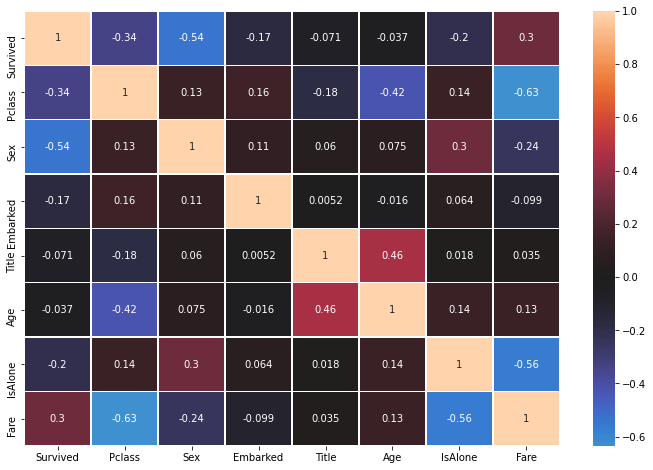

In [59]:
plt.figure(figsize = (12,8))
corr = df_train.corr()
sns.heatmap(corr, linewidths = 0.5, annot = True, center = 0, vmax = 1)

In [60]:
####Model Building####

In [61]:
x_train = df_train.drop('Survived', axis = 1)
y_train = df_train['Survived']
x_test = df_test
x_train.shape, y_train.shape, x_test.shape

((891, 7), (891,), (418, 7))

In [69]:
model_lr = LogisticRegression()
model_lr.fit(x_train, y_train)

prediction = model_lr.predict(x_test)

LR_Score = model_lr.score(x_train, y_train)*100
print(LR_Score)

79.34904601571269


In [70]:
model_svc = SVC(kernel = 'rbf', gamma = 3, C = 1)
model_svc.fit(x_train, y_train)

prediction = model_svc.predict(x_test)

SVC_Score = model_svc.score(x_train, y_train)*100
print(SVC_Score)

86.75645342312009


In [71]:
model_knn = KNeighborsClassifier(n_neighbors = 3)
model_knn.fit(x_train, y_train)

prediction = model_knn.predict(x_test)

KNN_Score = model_knn.score(x_train, y_train)*100
print(KNN_Score)

83.27721661054994


In [72]:
linear_svc = LinearSVC()
linear_svc.fit(x_train, y_train)

prediction = linear_svc.predict(x_test)

LSVC_Score = linear_svc.score(x_train, y_train)*100
print(LSVC_Score)

79.2368125701459


C:\Users\17706\Documents\Coding\Conda\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [73]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train, y_train)

prediction = decision_tree.predict(x_test)

DT_Score = decision_tree.score(x_train, y_train)*100
print(DT_Score)

86.75645342312009


In [74]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(x_train, y_train)

prediction = random_forest.predict(x_test)

RF_Score = random_forest.score(x_train, y_train)*100
print(RF_Score)

86.75645342312009


In [75]:
models = pd.DataFrame({
    'Model': ['SVM', 'KNN', 'Logistic Regression', 'Random Forest', 'LinearSVC', 'Decision Tree'],
    'Score': [SVC_Score, KNN_Score, LR_Score, RF_Score, LSVC_Score, DT_Score]})
models.sort_values(by='Score', ascending=False)

,Model,Score
0,SVM,86.756453
3,Random Forest,86.756453
5,Decision Tree,86.756453
1,KNN,83.277217
2,Logistic Regression,79.349046
4,LinearSVC,79.236813
